# Individual Skill Ratings

In [21]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

df = pd.read_json(path_or_buf="output/user_skill_graph-TEST.json", orient="records")
with open("pair-app-data/skill-words.json") as input_file:
    words = json.load(input_file)

df['categories'] = df['categories'].apply(tuple)
new_rows = []
for index, row in df.iterrows():
    new_rows.extend([[row['helperId'], row['timestamp'], row['task'][0], nn, row['value']] for nn in row.categories])
expanded_df = pd.DataFrame(new_rows,columns=['helperId', 'timestamp', 'task', 'category', 'value'])

skill_df = pd.read_csv('pair-app-data/skill-poll.csv')

In [22]:
def grab_user_responses(userId, pair_responses):
    user_responses = pair_responses[pair_responses['helperId'] == userId]
    return user_responses

def calculate_skill_scores(user_response_df):
    return user_response_df.groupby('category').mean()

def get_skill_scores(userId, pair_responses):
    res = grab_user_responses(userId, pair_responses);
    skill_df = calculate_skill_scores(res);
    return skill_df

---
Diff is equal to the (pair research skill - reported skill)


In [23]:
def find_diffs_and_values(userId, pair_responses, skill_responses):
    poll_skill_df = skill_df[skill_df["userId"] == userId]
    pair_skill_df = get_skill_scores(userId, pair_responses);

    transposed_poll_skill_df = poll_skill_df.T
    transposed_poll_skill_df.columns = ["value"]
    transposed_poll_skill_df.index = transposed_poll_skill_df.index.str.lower()
    
    result = {}
    for index, row in pair_skill_df.iterrows():
        if index in transposed_poll_skill_df.index:
            diff = (pair_skill_df.loc[index].value - transposed_poll_skill_df.loc[index]["value"])
            result[index] = {}
            result[index]["pairRating"] = pair_skill_df.loc[index].value
            result[index]["pollRating"] = transposed_poll_skill_df.loc[index]["value"]
            result[index]["diff"] = diff
    
    return result



def find_diffs(userId, pair_responses, skill_responses):
    poll_skill_df = skill_df[skill_df["userId"] == userId]
    pair_skill_df = get_skill_scores(userId, pair_responses);

    transposed_poll_skill_df = poll_skill_df.T
    transposed_poll_skill_df.columns = ["value"]
    transposed_poll_skill_df.index = transposed_poll_skill_df.index.str.lower()
    
    result = {}
    result["userId"] = userId
    for index, row in pair_skill_df.iterrows():
        if index in transposed_poll_skill_df.index:
            diff = (pair_skill_df.loc[index].value - transposed_poll_skill_df.loc[index]["value"])
            result[index] = diff
    
    return result


In [24]:
find_diffs("u6DrqFSvdZnWDgjz8", expanded_df, skill_df)

{u'algorithms': 0.0,
 u'brainstorming': -1.0,
 u'data analysis': -1.0,
 u'debugging': 1.0,
 u'dev tools': -1.3333333333333333,
 u'feedback': 1.0,
 u'general tech': -0.5,
 u'grants': 0.0,
 u'interaction design': 0.0,
 u'prototype testing': 0.5,
 u'research direction': -1.2000000000000002,
 u'study design': 0.5,
 u'ui/ux design': -0.5,
 'userId': 'u6DrqFSvdZnWDgjz8',
 u'web/mobile dev': -2.2999999999999998}

In [25]:
userIds = list(skill_df['userId'])
heatMapList = []
for userId in userIds:
    res = find_diffs(userId, expanded_df, skill_df)
    heatMapList.append(res);
heatMapList

[{u'algorithms': -3.0,
  u'brainstorming': -2.1000000000000001,
  u'data analysis': -1.0,
  u'debugging': 0.0,
  u'dev tools': 0.83333333333333348,
  u'feedback': -1.6000000000000001,
  u'general tech': -2.0,
  u'grants': 0.92857142857142838,
  u'interaction design': -1.6666666666666665,
  u'pair programming': -1.0,
  u'prototype testing': -1.6666666666666665,
  u'related work': 2.0,
  u'research direction': 0.75,
  u'study design': 0.75,
  u'ui/ux design': -1.8999999999999999,
  'userId': 'dZ23LYG2G42mY3NAf',
  u'web/mobile dev': -1.5714285714285716},
 {u'algorithms': 0.0,
  u'brainstorming': -0.92857142857142838,
  u'data analysis': -0.5,
  u'debugging': -2.0,
  u'dev tools': -2.3999999999999999,
  u'feedback': -1.1666666666666665,
  u'general tech': -2.0,
  u'grants': 1.8888888888888888,
  u'interaction design': -1.6666666666666665,
  u'pair programming': -3.0,
  u'prototype testing': -1.0,
  u'research direction': -0.29999999999999982,
  u'study design': -1.25,
  u'ui/ux design': -

In [38]:
heatMapDf = pd.DataFrame(heatMapList)
heatMapDf = heatMapDf.set_index(['userId'])
heatMapDf = heatMapDf[np.isfinite(heatMapDf['grants'])]
heatMapDf.values.max()

nan

In [27]:
def heatmap(df,
            edgecolors='w',
            cmap=mpl.cm.RdBu,
            log=False,vmin=0,vmax=500):    
    width = len(df.columns)/4
    height = len(df.index)/4
    
    fig, ax = plt.subplots(figsize=(width,height))
      
    heatmap = ax.pcolor(df,
                        edgecolors=edgecolors,  # put white lines between squares in heatmap
                        cmap=cmap,
                        vmin=vmin, # defaults to 0
                        vmax=vmax, # defaults to 500
                        norm=mpl.colors.LogNorm() if log else None)
    
    ax.autoscale(tight=True)  # get rid of whitespace in margins of heatmap
    ax.set_aspect('equal')  # ensure heatmap cells are square
    ax.xaxis.set_ticks_position('top')  # put column labels at the top
    ax.tick_params(bottom='off', top='off', left='off', right='off')  # turn off ticks
    
    plt.yticks(np.arange(len(df.index)) + 0.5, df.index)
    plt.xticks(np.arange(len(df.columns)) + 0.5, df.columns, rotation=90)
    
    # ugliness from http://matplotlib.org/users/tight_layout_guide.html
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "3%", pad="1%")
    plt.colorbar(heatmap, cax=cax)
    return fig

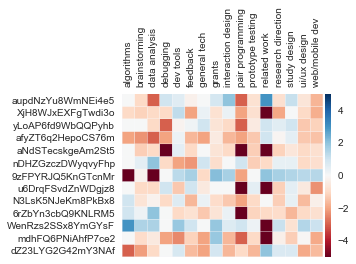

In [39]:
heatmap(heatMapDf, vmin=-5, vmax=5)

Diff is equal to the (pair research skill - reported skill). Most people seem to rate themselves higher than they do within the Pair Research Tool

In [40]:
heatMapDf.describe()

,algorithms,brainstorming,data analysis,debugging,dev tools,feedback,general tech,grants,interaction design,pair programming,prototype testing,related work,research direction,study design,ui/ux design,web/mobile dev
count,12.000000,13.000000,12.000000,12.000000,13.000000,13.000000,13.000000,13.000000,13.000000,10.000000,13.000000,8.000000,13.000000,13.000000,13.000000,13.000000
mean,-0.083333,-0.634049,-0.508333,-0.666667,0.032021,-0.648718,-0.474359,0.208164,-0.256410,-1.600000,-0.760203,0.875000,-0.240757,0.154396,-0.652767,-0.932525
std,1.505042,1.047318,1.671939,1.230915,1.330323,1.267826,1.092581,1.177863,1.248361,1.505545,0.657846,1.457738,1.079010,0.957159,1.040154,1.114740
min,-3.000000,-2.250000,-3.000000,-3.000000,-2.400000,-2.200000,-2.000000,-0.916667,-1.666667,-3.000000,-1.666667,-1.000000,-1.923077,-1.666667,-1.900000,-2.300000
25%,-0.250000,-1.142857,-1.000000,-1.250000,-1.000000,-1.666667,-1.333333,-0.692308,-1.333333,-2.750000,-1.214286,-0.250000,-1.153846,-0.600000,-1.333333,-1.714286
50%,0.000000,-0.928571,-1.000000,-0.500000,0.500000,-1.000000,0.000000,-0.461538,0.000000,-2.000000,-1.000000,1.000000,-0.300000,0.428571,-1.000000,-1.142857
75%,0.250000,0.000000,0.250000,0.000000,0.833333,0.200000,0.333333,0.928571,0.333333,-1.250000,-0.461538,2.000000,0.583333,0.750000,-0.500000,-0.814815
max,3.000000,1.545455,2.000000,1.000000,1.888889,1.666667,1.000000,2.125000,2.000000,1.000000,0.500000,3.000000,1.666667,1.500000,1.476190,1.416667


In [41]:
skill_df

,Timestamp,What's your name?,What is your current status in University?,How many quarters have you been in DTR?,userId,Prototype Testing,Needfinding,Brainstorming,Feedback,Interaction Design,...,General Tech,Dev Tools,Algorithms,Research Direction,Study Design,Paper Writing,Data Analysis,Grants,User Studies,Related Work
0,5/15/2017 15:45:10,Lily,Junior,2,dZ23LYG2G42mY3NAf,5,5,5,5,5,...,3,2,4,2,3,1,2,2,4,2
1,5/15/2017 15:47:43,Kapil Garg,Senior,5,mdhFQ6PNiAhfP7ce2,4,4,4,4,4,...,5,5,5,3,4,2,5,1,3,1
2,5/15/2017 16:01:06,Sasha,Junior,4,WenRzs2SSx8YmGYsF,3,2,2,3,2,...,3,1,1,2,3,1,2,1,2,2
3,5/15/2017 16:25:59,Eunice,Junior,1,6Yv3ARWJQMWtFKgnN,3,2,4,5,3,...,2,3,1,3,2,2,3,1,3,1
4,5/15/2017 16:56:55,Meg G,Junior,3,6rZbYn3cbQ9KNLRM5,4,2,3,3,3,...,4,3,3,3,3,4,2,2,2,3
5,5/15/2017 17:35:40,Allison Sun,Junior,3,N3LsK5NJeKm8PkBx8,5,4,4,5,5,...,3,2,2,4,3,4,2,4,4,3
6,5/15/2017 19:34:58,Bomani McClendon,Senior,4,u6DrqFSvdZnWDgjz8,3,3,5,3,4,...,4,3,2,4,2,1,3,1,4,3
7,5/15/2017 20:01:39,Morgan,Junior,2,9zFPYRJQ5KnGTcnMr,2,3,3,3,2,...,2,1,2,2,2,2,2,2,3,2
8,5/15/2017 21:48:25,Armaan Shah,Junior,1,9gcjpT4daYZmZDi2F,3,4,4,3,2,...,3,3,3,4,3,2,3,1,4,3
9,5/16/2017 10:15:14,Sarah Lim,Junior,7,nDHZGzczDWyqvyFhp,4,3,3,5,2,...,4,5,4,3,3,4,2,4,3,4
